### Loading the CLIP model

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import open_clip
import csv
import torch
from open_clip import tokenizer

model, _, preprocess = open_clip.create_model_and_transforms('convnext_base_w', pretrained='laion2b_s13b_b82k_augreg')

/Users/v/miniconda3/envs/aim2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# most of this code has been created by prompting ChatGPT and then editing and restructuring it for the needs of the project

### Selecting the text prompt and the language of film recommendations

The text prompt is the phrase/term that will be matched to film posters in the dataset

In [3]:
# Choose a text prompt
text_prompt = "watermelon"

# Choose the language for film recommendations - 'french', 'english', or 'hindi'
language = "hindi"

# Select the number of film recommendations
number = 5

### Encoding the text prompt & semantically matching the prompt to the film posters

The closest matches are selected as film recommendations.

The film recommendations for "watermelon" are:


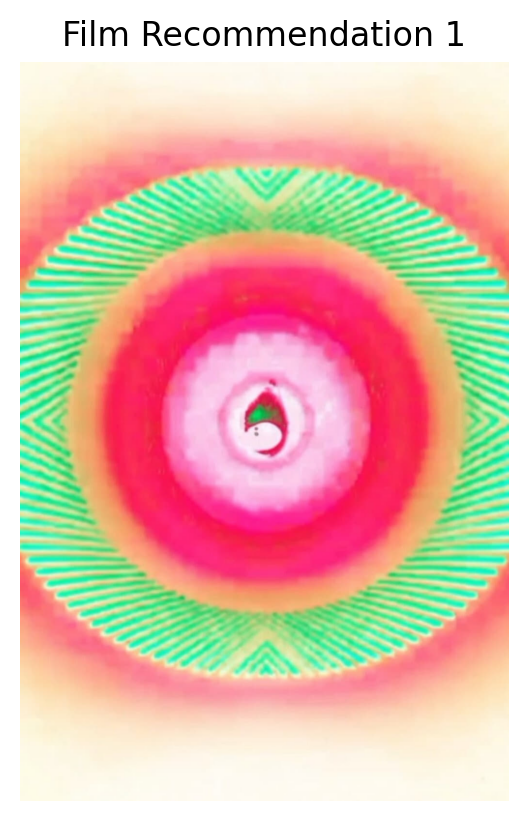

title: घूरो
original_title: घूरो
release_date: 
rating: 0.0
overview: paranoia depicted through color burned imagery.


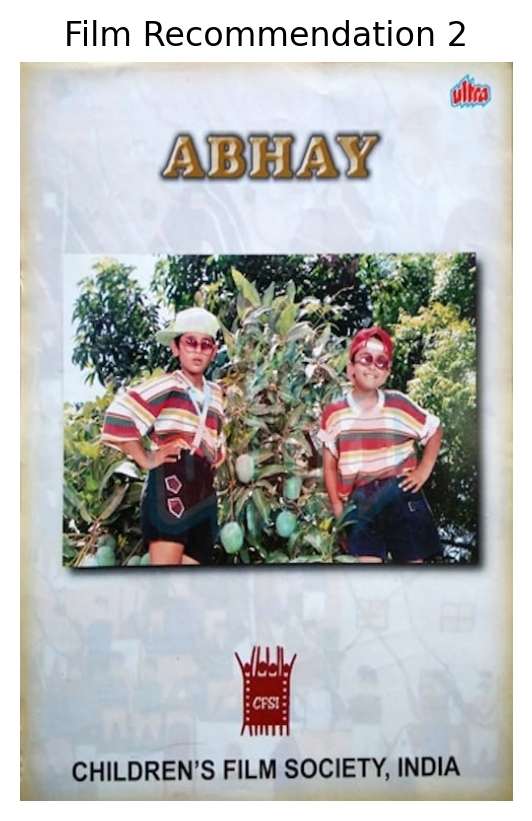

title: Abhay
original_title: अभय
release_date: 1995-01-01
rating: 0.0
overview: A happy family moved into a village and choose a Haveli as their abode. But they are not alone, a ghost is also there.


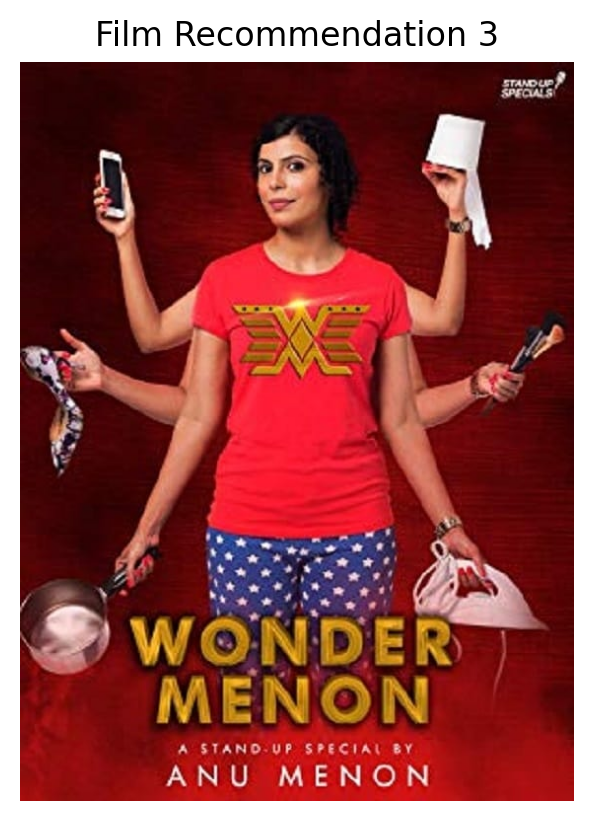

title: Anu Menon: Wonder Menon
original_title: Anu Menon: Wonder Menon
release_date: 2019-06-14
rating: 6.0
overview: 


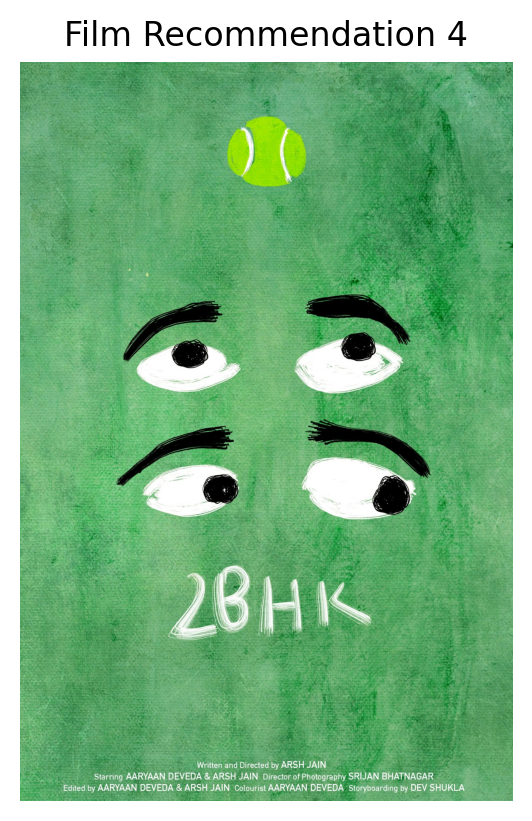

title: 2bhk
original_title: 2bhk
release_date: 2024-01-20
rating: 0.0
overview: 2 flatmates unfold the layers of their relationship on a random Sunday afternoon after they encounter a power cut.


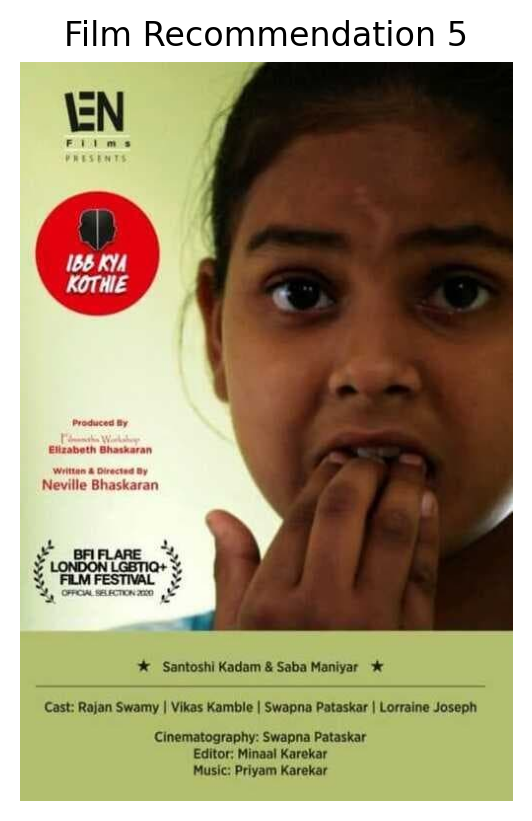

title: What Next Partner
original_title: Ibb Kya Kothie
release_date: 2019-01-01
rating: 0.0
overview: An unusually intimate look at Indian gender hierarchies, in which a young girl copes with having a hijara mother.


In [4]:
# setting a high resolution display
%config InlineBackend.figure_format = 'retina'

# global variables
folder_path = ""
csv_file_path = ""
encoded_features = ""

# function to load encoded features based on choice of language
def load_encoded_features(language):
    global folder_path, csv_file_path, encoded_features
    if language.lower() == "french":
        folder_path = "movie_posters_french_10k"
        csv_file_path = "movie_data_french_10k.csv"
        encoded_features = "french_poster_features.npy"
    elif language.lower() == "english":
        folder_path = "movie_posters_10k"
        csv_file_path = "movie_data_10k.csv"
        encoded_features = "poster_features.npy"
    elif language.lower() == "hindi":
        folder_path = "movie_posters_hindi_7k"
        csv_file_path = "movie_data_hindi_7k.csv"
        encoded_features = "hindi_poster_features.npy"
    else:
        print("Invalid language input. Defaulting to English.")
        folder_path = "movie_posters_10k"
        csv_file_path = "movie_data_10k.csv"
        encoded_features = "poster_features.npy"

# loading encoded features based on choice of language
load_encoded_features(language)

# function to encode the text prompt
def encode_text(query_text):
    query_tokens = tokenizer.tokenize([query_text])
    with torch.no_grad():
        query_features = model.encode_text(query_tokens).float()
    query_features /= query_features.norm(dim=-1, keepdim=True)
    return query_features.cpu().numpy()

# getting the list of image files in the specified folder
image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# encoding the text prompt
text_features = encode_text(text_prompt)

# loading the pre-encoded poster features
poster_features = np.load(encoded_features, allow_pickle=True)

# computing similarity scores between query text and poster features
similarities = np.dot(text_features, np.array(poster_features).reshape(len(poster_features), -1).T)

# finding the indices of the top closest matches
top_indices = np.argsort(similarities[0])[-number:][::-1]

# displaying the closest matches
print(f'The film recommendations for \"{text_prompt}\" are:')
for i, idx in enumerate(top_indices, start=1):
    matched_image_path = image_files[idx]
    matched_image = Image.open(matched_image_path)
    plt.imshow(matched_image)
    plt.title(f'Film Recommendation {i}')
    plt.axis('off')
    plt.show()

    # extracting the image filename without extension
    matched_image_name = os.path.splitext(os.path.basename(matched_image_path))[0]

    # converting the image filename to an integer
    matched_image_id = int(matched_image_name)

    # matching the filename (film id) to the film details in the CSV file
    with open(csv_file_path, 'r', newline='', encoding='utf-8') as csv_file:
        reader = csv.DictReader(csv_file)
        headers = reader.fieldnames
        if 'id' not in headers:
            print("Error: 'id' column not found in the CSV file.")
        else:
            for row in reader:
                if int(row['id']) == matched_image_id:

                    # printing film details 
                    print(f"title: {row['title']}")
                    print(f"original_title: {row['original_title']}")
                    print(f"release_date: {row['release_date']}")
                    print(f"rating: {row['vote_average']}")
                    print(f"overview: {row['overview']}")
                    break